# Modeling

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
plants = pd.read_csv('../data/data_cleaned/plants.csv')

In [12]:
plants.head()

id   created_utc                                              title  \
0  uw3f46  1.653321e+09                                   I feel attacked.   
1  v4z9xu  1.654380e+09    The liberals are trying to make my plants gay!!   
2  q0hqvn  1.633268e+09  This was supposed to be a plant progress post ...   
3  i5rplr  1.596855e+09                 My grandpa made me a plant stand ðŸ’–   
4  lkjvss  1.613414e+09  I let my Golden Pothos get outta hand for just...   

  self_text  comments  score  upvote_ratio  subreddit  
0   no_text       793  63651          0.94          1  
1   no_text      1281  54217          0.82          1  
2   no_text       572  45198          0.96          1  
3   no_text       451  40218          0.96          1  
4   no_text       593  39723          0.98          1

In [13]:
plants.shape

(9271, 8)

In [14]:
X = plants['title']
y = plants['subreddit']

In [15]:
X.shape

(9271,)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [17]:
tvec = TfidfVectorizer(stop_words = 'english')

In [18]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())

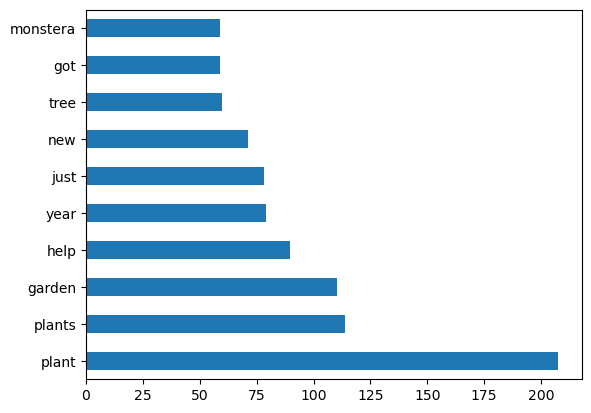

In [19]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [20]:
X_train.shape

(6953,)

In [21]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log_reg', LogisticRegression())
])

In [22]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('log_reg', LogisticRegression())])

In [23]:
pipe.score(X_train, y_train)

0.9082410470300589

In [24]:
pipe.score(X_test, y_test)

0.8321829163071613

In [25]:
1 - y.mean()

0.4891597454427785

In [26]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('log_reg', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'log_reg': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'log_reg__C': 1.0,
 'log_reg__class_weight': None,
 'log_reg__dual': False,
 'log_reg__fit_intercept': True,
 'log_reg__intercept_scaling': 1,
 'log_reg__l1_ratio': None,
 'log_reg__max_iter': 100,
 'log_reg__multi_class': 'auto',
 'log_reg__

In [27]:
pipe_params = {
    'tvec__max_features': [5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [2],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1, 1)]
}

In [28]:
gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv = 5)

In [29]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [5000],
                         'tvec__min_df': [2], 'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None, 'english']})

In [30]:
gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [31]:
gs.score(X_train, y_train)

0.8993240327916008

In [32]:
gs.score(X_test, y_test)

0.8274374460742019

In [33]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

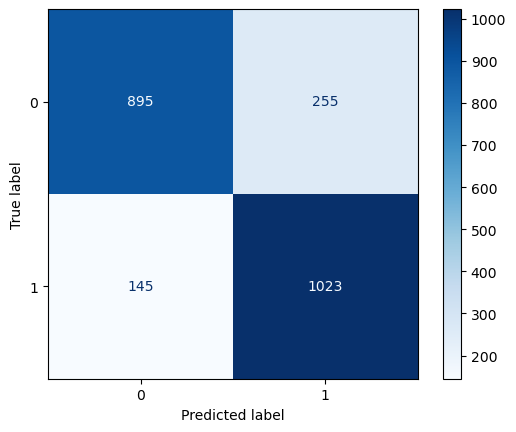

In [34]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues');

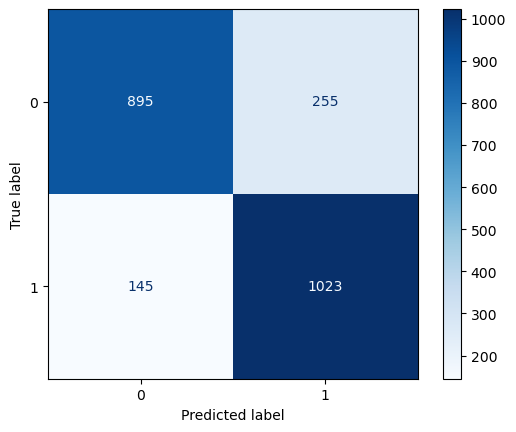

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='Blues');

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds, digits = 5))

              precision    recall  f1-score   support

           0    0.86058   0.77826   0.81735      1150
           1    0.80047   0.87586   0.83647      1168

    accuracy                        0.82744      2318
   macro avg    0.83052   0.82706   0.82691      2318
weighted avg    0.83029   0.82744   0.82698      2318

